In [19]:
!pip install tensorflow

In [20]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)


In [21]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization

In [22]:
print(os.listdir("../archive"))

print(len(os.listdir("../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")))
print(os.listdir("../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")[:5])

['New Plant Diseases Dataset(Augmented)', 'test']
38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


In [23]:
print(len(os.listdir("../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab")))
print(os.listdir("../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab")[:5])

2016
['00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG', '01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG', '01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_270deg.JPG', '01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_90deg.JPG', '01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_new30degFlipLR.JPG']


In [24]:
base_dir = "../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

(256, 256, 3)


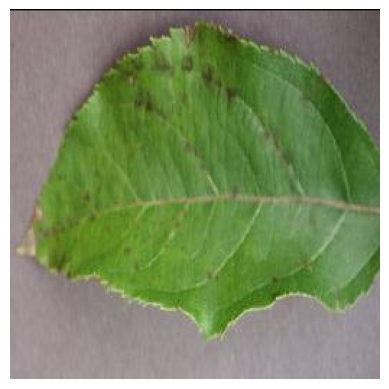

In [25]:
image_path="../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417_90deg.JPG"

img = mpimg.imread(image_path)

print(img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
img_size =224
batch_size = 32

In [27]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [28]:
train_generator =data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    subset = "training",
    class_mode = "categorical"
)

Found 56251 images belonging to 38 classes.


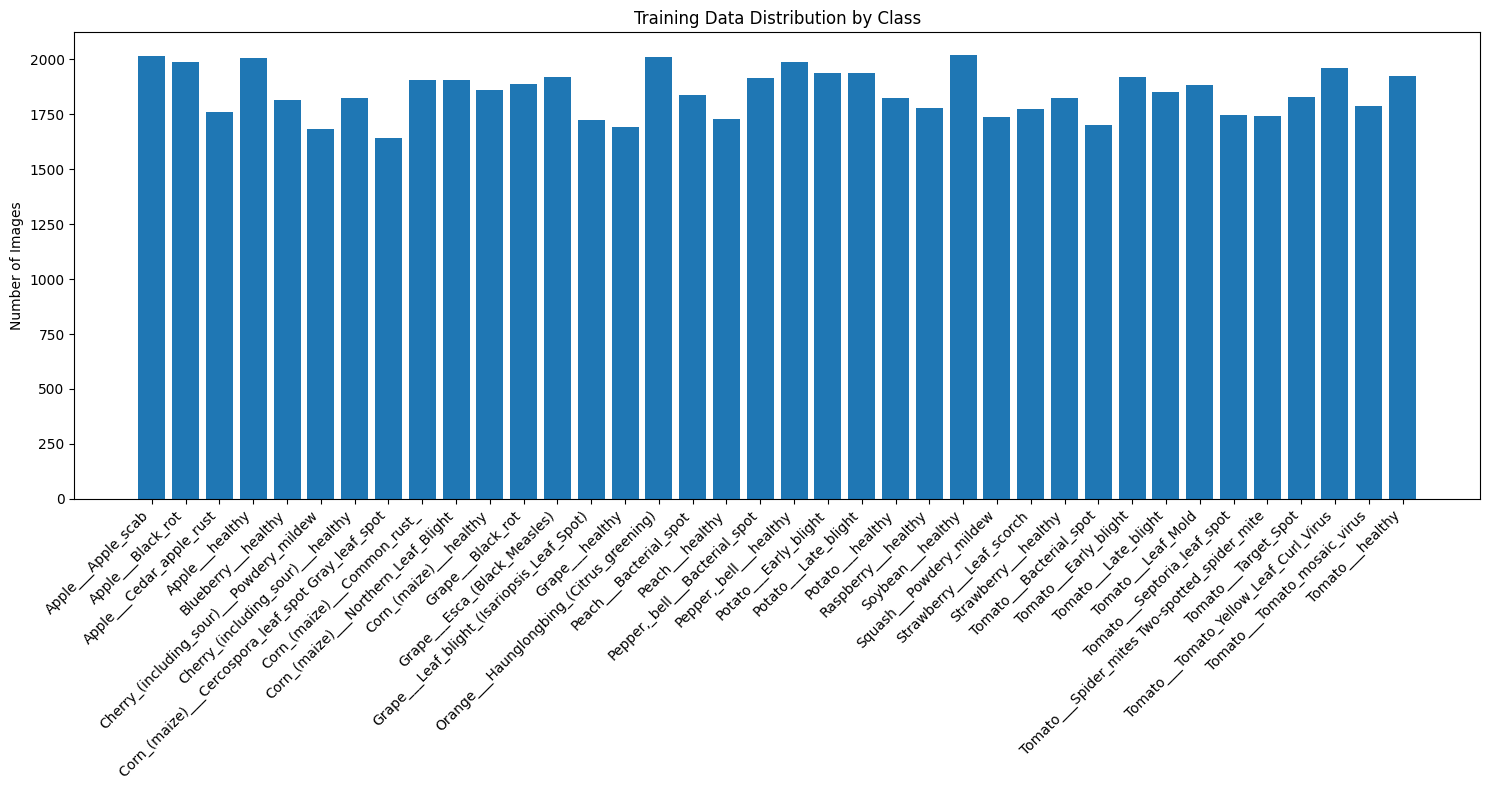

Class Distribution:
Apple___Apple_scab: 2016 images
Apple___Black_rot: 1987 images
Apple___Cedar_apple_rust: 1760 images
Apple___healthy: 2008 images
Blueberry___healthy: 1816 images
Cherry_(including_sour)___Powdery_mildew: 1683 images
Cherry_(including_sour)___healthy: 1826 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
Corn_(maize)___Common_rust_: 1907 images
Corn_(maize)___Northern_Leaf_Blight: 1908 images
Corn_(maize)___healthy: 1859 images
Grape___Black_rot: 1888 images
Grape___Esca_(Black_Measles): 1920 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 images
Grape___healthy: 1692 images
Orange___Haunglongbing_(Citrus_greening): 2010 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 1728 images
Pepper,_bell___Bacterial_spot: 1913 images
Pepper,_bell___healthy: 1988 images
Potato___Early_blight: 1939 images
Potato___Late_blight: 1939 images
Potato___healthy: 1824 images
Raspberry___healthy: 1781 images
Soybean___healthy: 2022 images
Squash_

In [29]:
# Check data balance
import matplotlib.pyplot as plt

class_counts = {}
for class_name in train_generator.class_indices.keys():
    class_dir = os.path.join(base_dir, class_name)
    count = len(os.listdir(class_dir))
    class_counts[class_name] = count

# Plot distribution
plt.figure(figsize=(15, 8))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Training Data Distribution by Class')
plt.tight_layout()
plt.show()

print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")
print(f"\nTotal images: {sum(class_counts.values())}")
print(f"Min: {min(class_counts.values())}, Max: {max(class_counts.values())}")

In [30]:
valid_dir = "../archive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 17572 images belonging to 38 classes.


In [31]:
# Load MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model initially

# Build the model
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,600,806 (9.92 MB)

 Trainable params: 340,262 (1.30 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [33]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch  = train_generator.samples//batch_size,
    epochs = 20,
    validation_data = validation_generator ,
    validation_steps=  validation_generator.samples//batch_size
)

Epoch 1/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2661s 2s/step - accuracy: 0.7876 - loss: 0.7175 - val_accuracy: 0.9131 - val_loss: 0.2656
Epoch 2/20
   1/1757 ━━━━━━━━━━━━━━━━━━━━ 8:34 293ms/step - accuracy: 0.7500 - loss: 0.7589

C:\Users\OMEN\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1757/1757 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.7500 - loss: 0.7589 - val_accuracy: 0.9129 - val_loss: 0.2658
Epoch 3/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2608s 1s/step - accuracy: 0.8606 - loss: 0.4379 - val_accuracy: 0.9218 - val_loss: 0.2375
Epoch 4/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.9688 - loss: 0.1664 - val_accuracy: 0.9220 - val_loss: 0.2380
Epoch 5/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2416s 1s/step - accuracy: 0.8727 - loss: 0.4020 - val_accuracy: 0.9275 - val_loss: 0.2247
Epoch 6/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 361s 205ms/step - accuracy: 0.8750 - loss: 0.3691 - val_accuracy: 0.9270 - val_loss: 0.2256
Epoch 7/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 3309s 2s/step - accuracy: 0.8784 - loss: 0.3814 - val_accuracy: 0.9283 - val_loss: 0.2178
Epoch 8/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 187s 106ms/step - accuracy: 0.9062 - loss: 0.2924 - val_accuracy: 0.9281 - val_loss: 0.2191
Epoch 9/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2717s 2s/step - accuracy: 0.8842 - loss

KeyboardInterrupt: 

In [38]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=20
)


50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8913 - loss: 0.3309 - val_accuracy: 0.9062 - val_loss: 0.2638


In [37]:
print("evaluating model ..")
val_loss,val_accuracy = model.evaluate(validation_generator,steps = validation_generator.samples//batch_size)
print(f"validation accuracy : {val_accuracy*100:.2f}%")
print(f"validation loss : {val_loss:.4f}")

# Get final training accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Overfitting indicator: {(final_train_acc - final_val_acc)*100:.2f}%")

evaluating model ..
549/549 ━━━━━━━━━━━━━━━━━━━━ 167s 304ms/step - accuracy: 0.9332 - loss: 0.2048
validation accuracy : 93.32%
validation loss : 0.2048


NameError: name 'history' is not defined

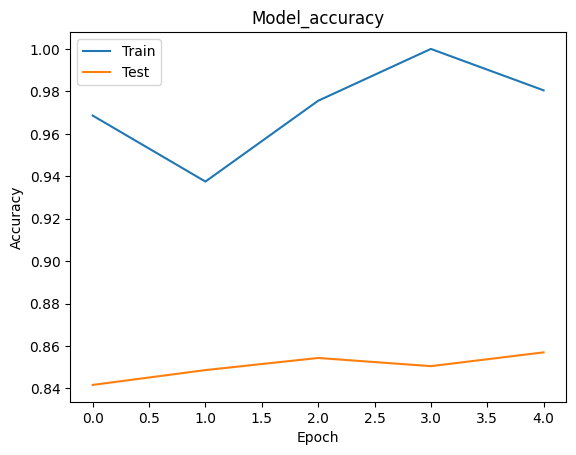

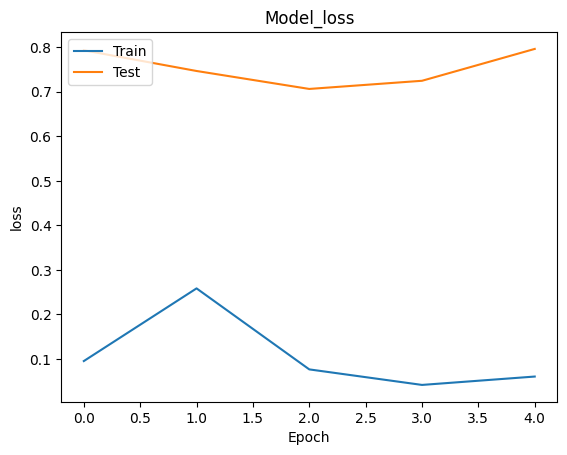

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc = 'upper left')
plt.show()

In [ ]:
print("Training History:")
for key, values in history.history.items():
    print(f"{key}: {values}")

Training History:
accuracy: [0.7155765891075134, 0.90625, 0.9094434380531311, 0.96875, 0.9541614055633545]
loss: [0.979016900062561, 0.3372526466846466, 0.2880544662475586, 0.17581890523433685, 0.13965696096420288]
val_accuracy: [0.799372136592865, 0.794377863407135, 0.858376145362854, 0.856877863407135, 0.8601598143577576]
val_loss: [0.6697611808776855, 0.6953864097595215, 0.47594720125198364, 0.48248687386512756, 0.5345703959465027]


In [ ]:
def load_and_preprocess_image(image_path,target_size = (224,224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array,axis = 0)
    img_array = img_array.astype('float32')/255
    return img_array
def predict_image_class(model,image_path,class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions,axis = 1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    return predicted_class_name, confidence

In [ ]:
class_indices = {v :k for k,v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '